In [1]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import sounddevice as sd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
data_path =r'C:\Users\user\Desktop\emotions'

In [3]:
def extract_spectrogram(file_path, n_mels=128, fmax=8000):
    y, sr = librosa.load(file_path, sr=None)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram_db


In [4]:
def pad_spectrogram(spectrogram, max_len):
    if spectrogram.shape[1] > max_len:
        return spectrogram[:, :max_len]  # Truncate to the max_len
    else:
        pad_width = max_len - spectrogram.shape[1]
        return np.pad(spectrogram, ((0, 0), (0, pad_width)), mode='constant')

In [5]:
def load_data(data_path, max_len=216):
    X = []
    y = []
    
    # Walk through all files in the directory
    for dirpath, _, filenames in os.walk(data_path):
        for filename in filenames:
            if filename.endswith('.wav'):
                file_path = os.path.join(dirpath, filename)
                spectrogram = extract_spectrogram(file_path)
                
                # Pad spectrogram to ensure uniform shape
                padded_spectrogram = pad_spectrogram(spectrogram, max_len)
                
                X.append(padded_spectrogram)
                
                # Extract label from filename (adjust based on your dataset)
                label = filename.split('-')[2]  # Assuming emotion is encoded in the filename
                y.append(label)
    
    return np.array(X), np.array(y)

In [6]:
# Load data
X, y = load_data(data_path, max_len=216)  # Adjust max_len as needed

# Reshape X to fit CNN input shape (samples, height, width, channels)
X = np.expand_dims(X, axis=-1)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_encoded = to_categorical(y_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [7]:
model = Sequential()

# First Conv2D layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model.add(MaxPooling2D((2, 2)))

# Second Conv2D layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Third Conv2D layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten and Dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 214, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 107, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 105, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 52, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 44800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       5,734,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,828,232 (22.23 MB)

 Trainable params: 5,828,232 (22.23 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr])


Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 36s 569ms/step - accuracy: 0.1337 - loss: 22.2033 - val_accuracy: 0.1475 - val_loss: 2.0486 - learning_rate: 0.0010
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 32s 560ms/step - accuracy: 0.2120 - loss: 2.0091 - val_accuracy: 0.2581 - val_loss: 1.9286 - learning_rate: 0.0010
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 32s 560ms/step - accuracy: 0.2986 - loss: 1.8828 - val_accuracy: 0.3883 - val_loss: 1.6206 - learning_rate: 0.0010
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 32s 559ms/step - accuracy: 0.4439 - loss: 1.5469 - val_accuracy: 0.4056 - val_loss: 1.5864 - learning_rate: 0.0010
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 33s 566ms/step - accuracy: 0.4819 - loss: 1.4068 - val_accuracy: 0.4902 - val_loss: 1.3441 - learning_rate: 0.0010
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 34s 585ms/step - accuracy: 0.5155 - loss: 1.2860 - val_accuracy: 0.4729 - val_loss: 1.4025 - learning_rate: 0.0010
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 34s 592ms/step - accuracy: 0.5915 - loss: 1

In [9]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.7646 - loss: 0.8684
Test loss: 0.8108940720558167
Test accuracy: 0.78125


Text(0.5, 1.0, 'Model Accuracy')

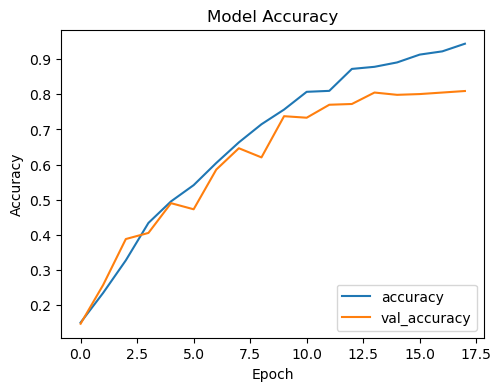

In [10]:
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy')

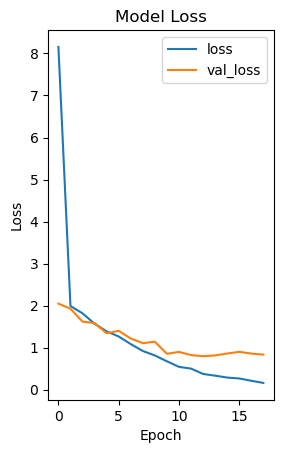

In [11]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Model Loss')

plt.show()

In [12]:
def record_audio(duration=2, sr=22050):
    print("Recording...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1)
    sd.wait()  # Wait until the recording is finished
    print("Recording finished")
    return np.squeeze(audio)

In [13]:

def process_audio(audio, sr=22050, max_len=216):
    # Extract spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    # Pad or truncate to the required length
    padded_spectrogram = pad_spectrogram(mel_spectrogram_db, max_len)
    
    # Reshape to fit model input
    padded_spectrogram = np.expand_dims(padded_spectrogram, axis=-1)
    padded_spectrogram = np.expand_dims(padded_spectrogram, axis=0)
    
    return padded_spectrogram

In [14]:
def predict_emotion(model, processed_audio):
    prediction = model.predict(processed_audio)
    predicted_label = np.argmax(prediction, axis=1)
    return predicted_label


In [15]:

def get_emotion_label(prediction, label_encoder):
    return label_encoder.inverse_transform(prediction)

In [28]:
import sounddevice as sd

def real_time_emotion_recognition(model, label_encoder, duration=3, sr=22050):
    # Step 1: Display message and record audio
    audio = record_audio(duration=duration, sr=sr)
    
    if audio is None:
        print("Recording failed. Please try again.")
        return
    
    # Step 2: Ask if the user wants to play back the recorded audio
    play_back = input("Do you want to play back the recorded voice? (yes/no): ").strip().lower()
    
    if play_back == 'yes':
        print("Playing back your recorded voice...")
        sd.play(audio, sr)
        sd.wait()  # Wait until playback is finished
    else:
        print("Skipping playback.")
    
    # Step 3: Process the audio
    processed_audio = process_audio(audio, sr=sr)
    
    # Step 4: Predict emotion
    prediction = predict_emotion(model, processed_audio)
    
    # Step 5: Get emotion label
    emotion = get_emotion_label(prediction, label_encoder)
    
    # Step 6: Display predicted emotion
    print(f'Predicted Emotion: {emotion[0]}')

# Example usage: Run real-time emotion recognition
real_time_emotion_recognition(model, le)


Recording...
Recording finished


Do you want to play back the recorded voice? (yes/no):  yes


Playing back your recorded voice...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Emotion: 03


In [ ]:
#01  correspond to a specific emotion like "neutral."
#02  correspond to "calm."
#03  correspond to "happy."
#04  correspond to "sad."